This is the fourth simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using a more realistic detector model now with 32 detector layers separated into 32 bins. The layers are stacked straight, not following the curve of the ring, and tracks are curved. Each bin only registers hit/no hit, with 100% efficiency. Assume hits are still Gaussian distributed before registering.

Training on large parameter range with 1e6 samples.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.special import erf
import types
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

In [3]:
#layers at fixed z, giving x position
#source has x,z,px,pz
# B=1.45

#each tracker module has 4 layers of 32 straws, 8 modules in a station
#straw tube is 5mm diameter
#muons decay 5-10m from first layer
#momentum (0.5-3)e3 MeV
#300 mu-m radial position resolution
#4cm between outer layers of one module
#~6cm from center of module to edge?
#1mm between the two U-layers


#layers of 32 5mm bins, 1mm separated, 1cm between "twin" layers
#
# __ __ __ __
#__ __ __ __
#
#__ __ __ __
# __ __ __ __

#2cm between U and V, 4cm between modules

det_zs = np.ones((8,4))
det_zs[:,0] *= 0
det_zs[:,2] *= 3
det_zs[:,3] *= 4
for i in range(1,8):
    det_zs[i] += i*8
det_zs = det_zs.flatten()*1e-2
    
N_bins = 32
N_det = len(det_zs)

det_xs = np.tile(np.array([(i*6+2.5)*1e-3 for i in range(32)]),(N_det,1)) #i = z, j = x
#leftshift_idx = [1,2,5,6,9,10,13,14] #i//2 even and i%2 odd or i//2 odd and i%2 even
det_xs[[((i//2)%2 == 0 and (i%2) == 1) or ((i//2)%2 == 1 and (i%2) == 0) for i in range(N_det)]] -= 2.5e-3
det_xs += (4.5 + 2)*1e-2 #distance to storage volume center

### Tracker toy model

Muon decaying at (x=0,z), producing positron with momentum (px,pz). 8 layers at given z (infinite in x) that will return x position (Gaussian). $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$v_x = A\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$v_z = A\cos(\frac{qB}{\gamma m} t + \phi)$

$|v|^2 = v_x^2 + v_z^2 = A^2$<br/>
$p_x = |p|\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$p_z = |p|\cos(\frac{qB}{\gamma m} t + \phi)$

$\tan \phi = \frac{v_x(0)}{v_z(0)} = \frac{p_x(0)}{p_z(0)}$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T + \phi) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T + \phi) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|}) - \phi)$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi$ (from the z-axis):<br/>
$x = \frac{p\cos(\phi)}{qB} - \frac{1}{qB}\sqrt{p^2\cos^2(\phi) - q^2B^2z^2 -2qBzp\sin(\phi)}$

In [58]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45

def calc_x(z,p,phi):
    # p is in GeV -> *1e9/c
    p *= 1e9/c
    
    sq = p**2*np.cos(phi)**2 - B**2*z**2 - 2*B*z*p*np.sin(phi)
    #take square root where possible
    sq[sq>0] = np.sqrt(sq[sq>0])
    
    res = (p*np.cos(phi) - sq)/B
    #where result is unphysical, set to -1
    res[sq<0] = -1
    
    return res

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#example event z_toy,p_toy,phi_toy
#toy=[-0.56,1.8,0.05] #this produces hits in almost every layer
toy=[-0.34,1.9,0.06] #this is an event with fewer hits, leaving bottom layers w/o hits
z_toy, p_toy, phi_toy = toy

#for Gaussian
sigma = 3e-4

In [5]:
def generate_event(z, p, phi):
    # generates an event from given z, p, phi
    # returns length N_det array of centers of hit bins
    
    hits = np.zeros(N_det)
    dist = det_zs-z
    x_exp = calc_x(dist,p,phi)
    for i in range(N_det):
        x_meas = x_hit(x_exp[i],sigma).rvs()
        #check if x_exp < or > than end of detector (incl. -1)
        if x_meas < det_xs[i,0]-2.5e-3 or x_meas > det_xs[i,-1]+2.5e-3: continue
        
        #figure out which bin it would hit
        j = (np.abs(det_xs[i] - x_meas)).argmin()
        if np.abs(x_meas-det_xs[i,j]) <= 2.5e-3:
            hits[i] = det_xs[i,j]
    return hits

#toy MC
def MC_events(N_events, zlims=(-1, -0.001), plims=(0.5,3.0),phi_lims=(0,0.1), verbose_lvl=0):
    '''
    sample source parameters from uniform distribution of x, p, and phi #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    
    z = []
    p = []
    phi = []
    events = []
    
    while len(events)<N_events:
        # number of events to go
        n_evs = N_events-len(events)
        if verbose_lvl == 2:
            print("# events done:",len(events))
            print("# events to go:",n_evs)
        _z = np.random.uniform(*zlims, n_evs)
        _p = np.random.uniform(*plims, n_evs)
        _phi = np.random.uniform(*phi_lims, n_evs)
        for i in range(n_evs):
            _ev = generate_event(_z[i],_p[i],_phi[i])
        
            #check if particle produces at least 5 hits (3 layers)
            if np.sum(_ev>0)>4:
                z.append(_z[i])
                p.append(_p[i])
                phi.append(_phi[i])
                events.append(_ev)
                if verbose_lvl >= 1:
                    if len(events)%(N_events//10) == 0: print(N_events//10,"events done")
        if verbose_lvl == 2:
            print("# events thrown out:",N_events - len(events))
    
    truth = np.asarray((z, p, phi)).T
    assert truth.shape[0] == len(events)
        
    return events, truth

In [6]:
def plot_event(ev):
    #plt scatter, then scatter event in red on top
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i in range(N_det):
        ax.scatter(det_xs[i],np.ones(N_bins)*det_zs[i],marker="_",s=100,color="grey")
    ax.scatter(ev[ev>0],det_zs[ev>0],marker="_",s=100,color="red")
    
    #ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

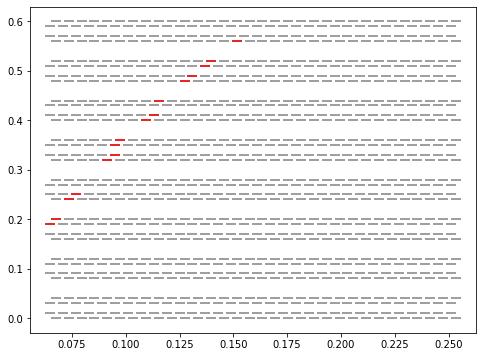

In [59]:
ev = generate_event(*toy)
#print(ev)
plot_event(ev)

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [9]:
#log-likelihoods

#using the "alternative" method here to make it easier, we know about the step structure now
def hit_pdf(x_meas,z,p,phi):
    xs = calc_x(det_zs-z,p,phi)

    llh = 0
    pmf=1
    
    for i,hit in enumerate(x_meas):
        #if we registered a hit
        if hit>0:
            #integrate Gaussian over bin area -> erf
            pmf *= 0.5*(erf((hit+2.5e-3-xs[i])/sigma/np.sqrt(2)) - erf((hit-2.5e-3-xs[i])/sigma/np.sqrt(2)))
        #if we didn't register a hit
        else:
            #if particle doesn't reach layer
            if xs[i] < 0:
                continue #pmf *= 1
            else:
                #determine closest gaps: n, n-1, n+1
                n = (xs[i]+5.5e-3)//6e-3
                pmf_s = 0
                for m in [n-1, n, n+1]:
                    gap_end = m*6e-3 + 0.5e-3
                    #integrate over gap
                    pmf_s += 0.5*(erf((gap_end-xs[i])/sigma/np.sqrt(2)) - erf((gap_end-1e-3-xs[i])/sigma/np.sqrt(2)))
                pmf *= pmf_s
    if pmf==0: llh=-710
    else: llh = np.log(pmf)    
    
    #store negative LLH, multiply by -1
    return -llh

In [60]:
grid_spacing = 100

#full range
zs = np.linspace(-1, -0.1, grid_spacing)
ps = np.linspace(0.5, 3.0, grid_spacing)
phis = np.linspace(0, 0.1, grid_spacing)

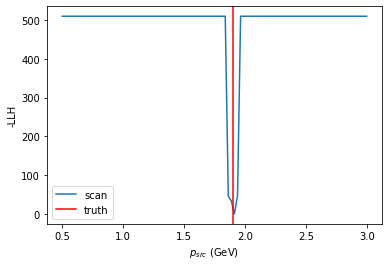

In [61]:
llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

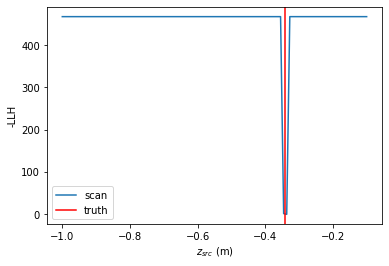

In [62]:
llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

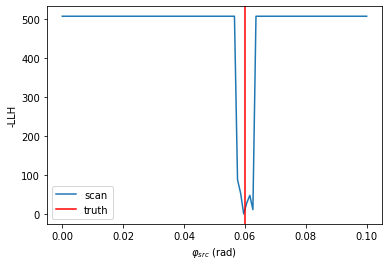

In [63]:
llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

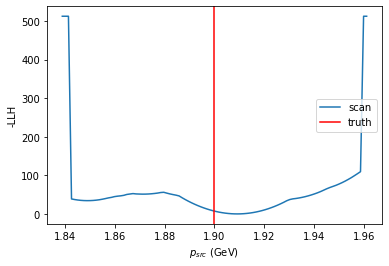

In [67]:
#zooming in
#p_zoom = (1.772,1.828)
p_zoom = (1.839,1.961)
ps = np.linspace(*p_zoom, grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

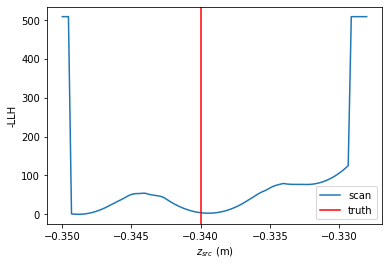

In [71]:
#z_zoom = (-0.568,-0.552)
z_zoom = (-0.350,-0.328)
zs = np.linspace(*z_zoom, grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

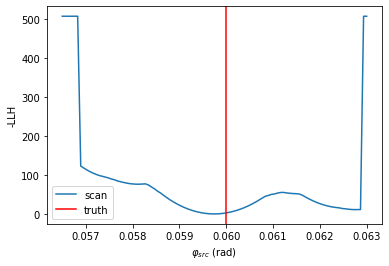

In [73]:
#phi_zoom = (0.0478, 0.0522)
phi_zoom = (0.0565, 0.063)
phis = np.linspace(*phi_zoom, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

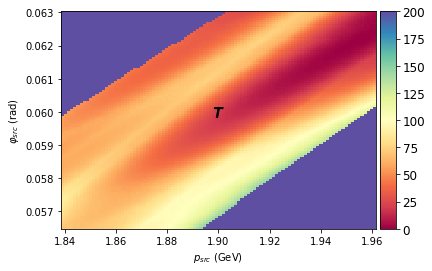

In [74]:
llh_p_phi_scan = map_2d(hit_pdf, ev, (1, 2), (ps, phis), toy)

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=200)

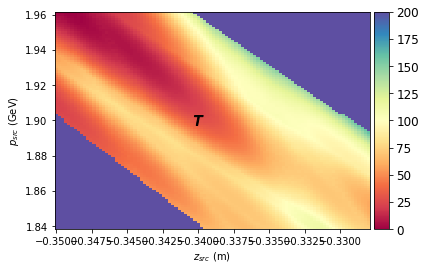

In [75]:
llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), toy)

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=200)

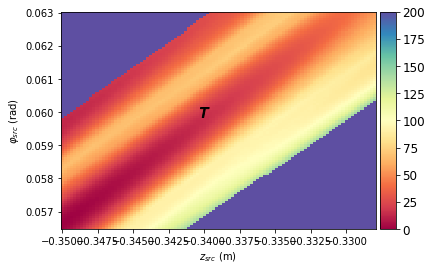

In [76]:
llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), toy)

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=200)

In [30]:
#make toy MC data for neural net training
N_mc = int(1e6)
mc, truth = MC_events(N_mc,verbose_lvl=2)

# events done: 0
# events to go: 1000000
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
# events thrown out: 101484
# events done: 898516
# events to go: 101484
100000 events done
# events thrown out: 10164
# events done: 989836
# events to go: 10164
# events thrown out: 981
# events done: 999019
# events to go: 981
# events thrown out: 91
# events done: 999909
# events to go: 91
# events thrown out: 7
# events done: 999993
# events to go: 7
# events thrown out: 1
# events done: 999999
# events to go: 1
100000 events done
# events thrown out: 0


In [31]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

#separate the hits into single events, add the detector z position
hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

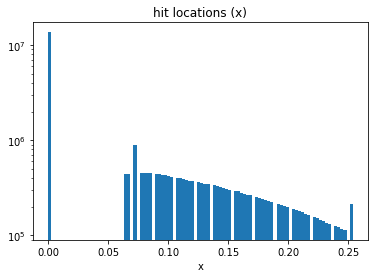

In [32]:
#histogram of hit positions (x) = bin centers
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [33]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

hitnet.trafo = trafo

In [34]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [35]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         trafo[0][0]                  

In [36]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [37]:
#training

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
12500/12500 [==============================] - 931s 74ms/step - loss: 0.3819 - val_loss: 0.3036
Epoch 2/5
12500/12500 [==============================] - 1040s 83ms/step - loss: 0.3206 - val_loss: 0.3156
Epoch 3/5
12500/12500 [==============================] - 959s 77ms/step - loss: 0.3173 - val_loss: 0.3035
Epoch 4/5
12500/12500 [==============================] - 916s 73ms/step - loss: 0.3130 - val_loss: 0.3061
Epoch 5/5
12500/12500 [==============================] - 753s 60ms/step - loss: 0.3118 - val_loss: 0.3019


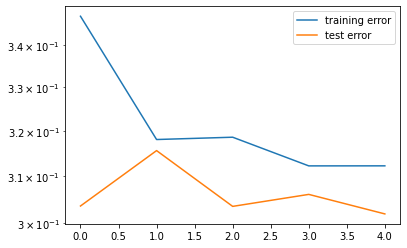

In [38]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

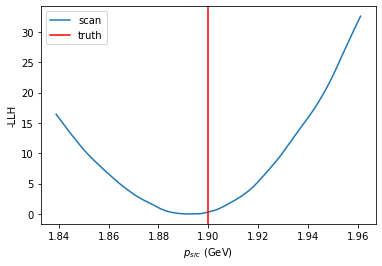

In [77]:
#neural net scan
#ps = np.linspace(*p_zoom,grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,ps,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

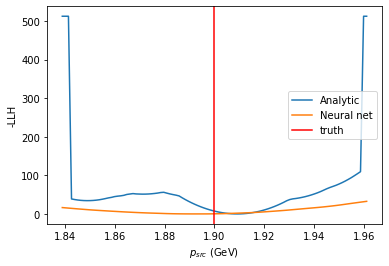

In [78]:
#comparison NN and analytical
#llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_diff(llh_p_scan, nn_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

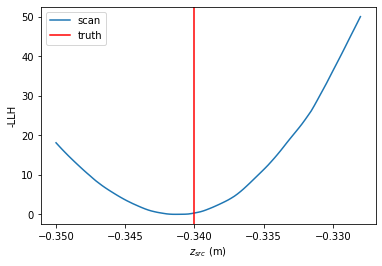

In [79]:
#neural net scan
#zs = np.linspace(*z_zoom,grid_spacing)

scan_t = np.vstack([zs,np.ones(grid_spacing)*p_toy,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

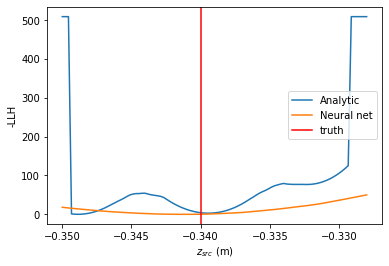

In [80]:
#comparison NN and analytical
#llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$z_{src}$ (m)')

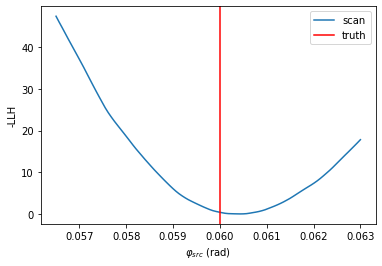

In [81]:
#neural net scan
#phis = np.linspace(*phi_zoom,grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy,phis]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])

nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')

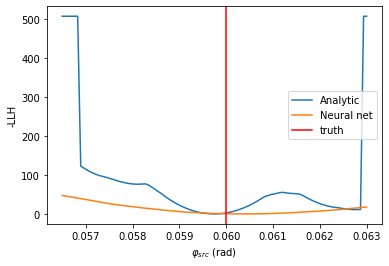

In [82]:
#comparison NN and analytical
#llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_diff(llh_phi_scan, nn_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

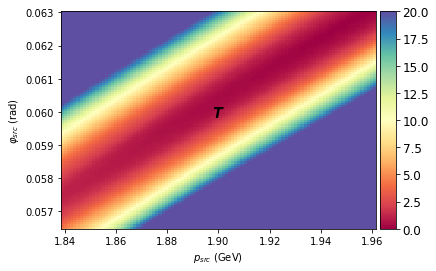

In [83]:
#neural net scan
mg = np.meshgrid(ps,phis)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*z_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_p_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_p_phi_scan, ps, phis, p_toy, phi_toy, 
            axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=20)

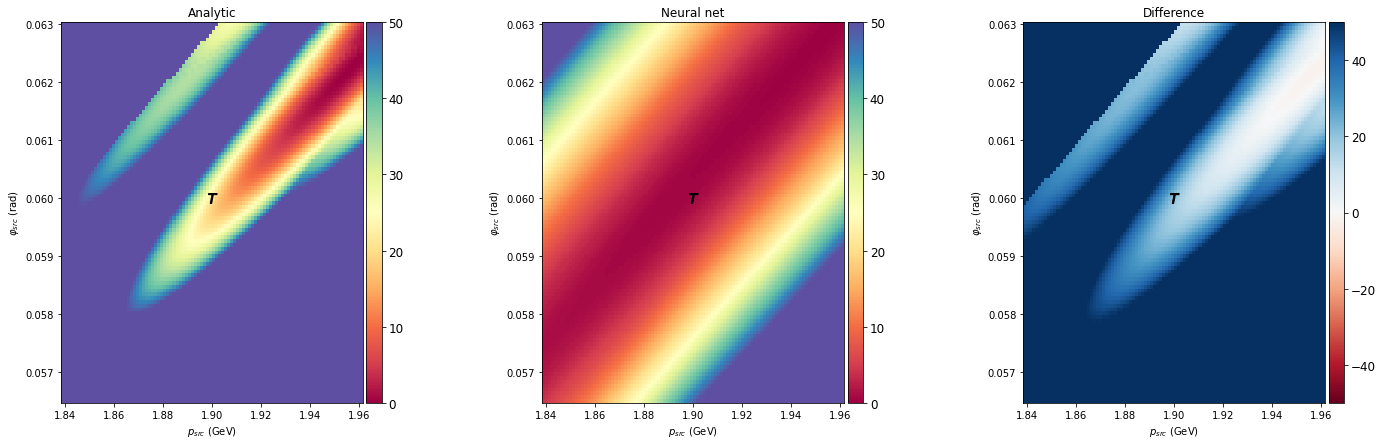

In [84]:
#comparison
#llh_p_phi_scan = map_2d(hit_pdf, ev, (1,2), (ps,phis), toy)

plot_2d_diff(llh_p_phi_scan, NN_p_phi_scan, ps, phis, p_toy, phi_toy,
             axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=50,vmax_d=50)

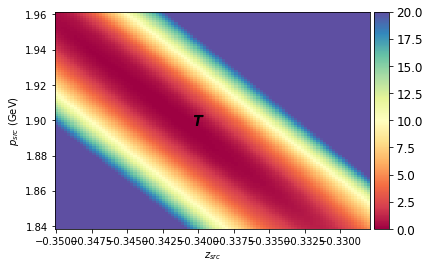

In [85]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*phi_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'],vmax=20)

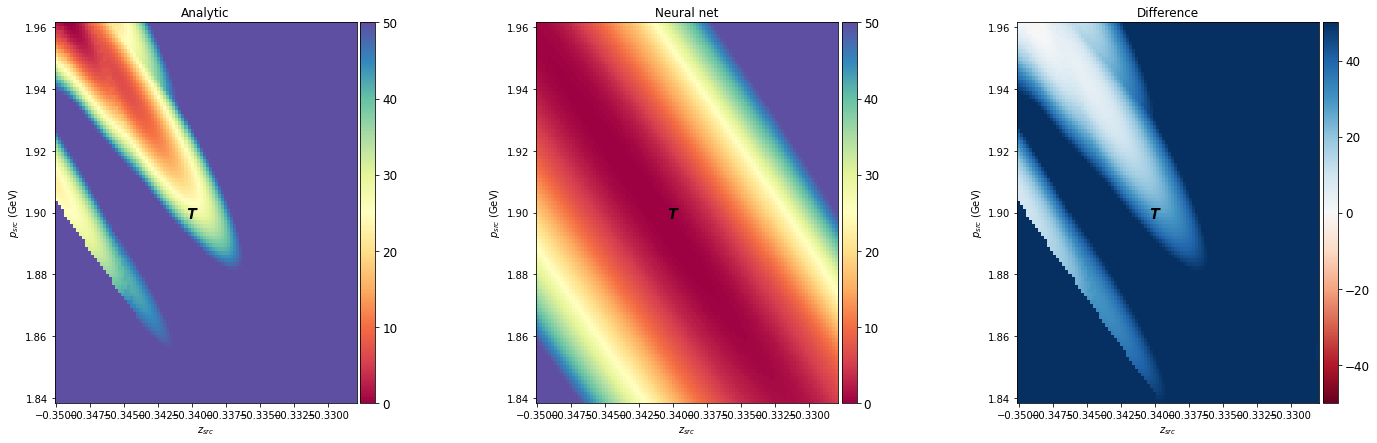

In [86]:
#comparison
#llh_z_p_scan = map_2d(ev, (0, 1), (zs,ps),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_z_p_scan, NN_z_p_scan, zs, ps, z_toy, p_toy,
             axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'],vmax=50,vmax_d=50)

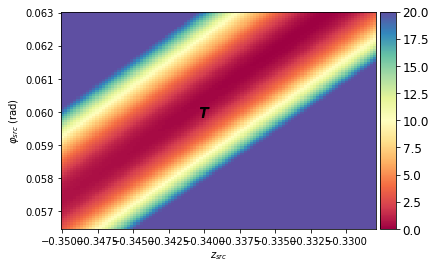

In [87]:
#neural net scan
mg = np.meshgrid(zs,phis)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*p_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_phi_scan, zs, phis, z_toy, phi_toy, 
            axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'],vmax=20)

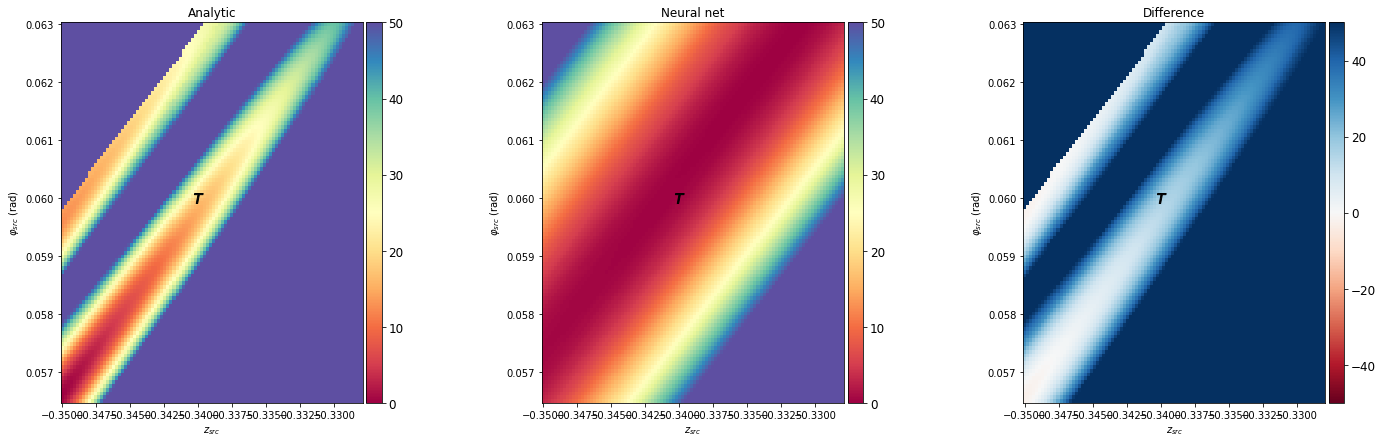

In [88]:
#comparison
#llh_z_phi_scan = map_2d(ev, (0, 2), (zs,phis),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_z_phi_scan, NN_z_phi_scan, zs, phis, z_toy, phi_toy,
             axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'],vmax=50,vmax_d=50)

In [89]:
#minimize analytic likelihood
def ana_llh(theta,event):
    #wrapper funtion
    return hit_pdf(event,*theta)

print(*toy)
true_llh_ana = ana_llh(toy,ev)
print(true_llh_ana)

-0.34 1.9 0.06
205.1024835616451


In [90]:
#minimize nn output
def nn_llh(theta, event):
    #wrapper function
    
    #reshape events into 8x2 array 
    event = np.vstack((event,det_zs)).T

    #repeat truth for each hit in event
    theta = np.array(theta)
    theta = np.repeat(theta[np.newaxis,:], N_det, axis=0)

    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([event,theta])
    return -1*pred.sum()

print(*toy)
true_llh_nn = nn_llh(toy,ev)
print(true_llh_nn)

-0.34 1.9 0.06
-56.687530517578125


In [53]:
def bound_min(min_fct, x0, bounds, ev):
    #run a bound minimizer
    
    #x0 starting guess
    #bounds must be list of tuples, len = len(x0)
    opt_params = minimize(min_fct,x0,args=(ev),method='Powell',bounds=bounds,options={'maxiter':100000})
    
    print("starting guess:",x0)
    if opt_params.success:
        print("function value:",opt_params.fun)
        print("\nerrors:")
        print("z (mm):",1000*(opt_params.x[0]-z_toy))
        print("p (MeV):",1000*(opt_params.x[1]-p_toy))
        print("phi (rad):",(opt_params.x[2]-phi_toy))
        print("\nrelative error (%):")
        print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])
        print("\n")
        
    else: print("Minimization failed!")
        
    return opt_params.fun, opt_params.x

In [91]:
#minimize analytic llh with different starting guesses
_, opt_ana = bound_min(ana_llh,[z_zoom[0],p_zoom[0],phi_zoom[0]],[z_zoom,p_zoom,phi_zoom],ev)
_, opt_ana = bound_min(ana_llh,[z_zoom[1],p_zoom[1],phi_zoom[1]],[z_zoom,p_zoom,phi_zoom],ev)
#try truth as starting guess, see where we land (assume that's global min)
f_ana, opt_ana = bound_min(ana_llh,toy,[z_zoom,p_zoom,phi_zoom],ev)

starting guess: [-0.35, 1.839, 0.0565]
function value: 204.23081561741515

errors:
z (mm): 1.0258645007669154
p (MeV): 0.45791318408783255
phi (rad): 9.233421121847274e-05

relative error (%):
[-0.30172485  0.02410069  0.15389035]


starting guess: [-0.328, 1.961, 0.063]
function value: 175.93612012241078

errors:
z (mm): -8.836421772358992
p (MeV): 60.991231866211805
phi (rad): 8.29713297779977e-06

relative error (%):
[2.59894758 3.21006484 0.01382855]


starting guess: [-0.34, 1.9, 0.06]
function value: 183.26918716448463

errors:
z (mm): -2.0030454811549303
p (MeV): 54.09683007903787
phi (rad): 0.001496766113766701

relative error (%):
[0.58913102 2.84720158 2.49461019]




For events with many hits, truth starting guess gives good result. Other guesses are a few percent off in at least one parameter.

For events with fewer hits, 1-D and 2-D scans show that truth is actually not most likely, and that there are local minima around. Minimizer performs ok overall, finds close to truth once and few percent off with other guesses.

In [92]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(nn_llh,[z_zoom[0],p_zoom[0],phi_zoom[0]],[z_zoom,p_zoom,phi_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.35, 1.839, 0.0565]
function value: -57.49695587158203

errors:
z (mm): 3.7805402296306467
p (MeV): 34.26371425060948
phi (rad): 0.002999836435230399

relative error (%):
[-1.1119236   1.80335338  4.99972739]


LLH of truth (NN/ana): -56.687530517578125 205.1024835616451
NN llh of found min: -57.49695587158203
Analytic llh of found min (NN/ana): 202.91481055828703 183.26918716448463


In [93]:
f_nn, opt_nn = bound_min(nn_llh,[z_zoom[1],p_zoom[1],phi_zoom[1]],[z_zoom,p_zoom,phi_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.328, 1.961, 0.063]
function value: -57.480072021484375

errors:
z (mm): 0.7184516350782766
p (MeV): 48.23182874858478
phi (rad): 0.0028063859875244873

relative error (%):
[-0.2113093   2.5385173   4.67730998]


LLH of truth (NN/ana): -56.687530517578125 205.1024835616451
NN llh of found min: -57.480072021484375
Analytic llh of found min (NN/ana): 198.63349436539878 183.26918716448463


In [94]:
f_nn, opt_nn = bound_min(nn_llh,toy,[z_zoom,p_zoom,phi_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.34, 1.9, 0.06]
function value: -57.021610260009766

errors:
z (mm): -1.3265873290849162
p (MeV): -0.5148313176372987
phi (rad): 1.8620640500038865e-05

relative error (%):
[ 0.39017274 -0.02709639  0.0310344 ]


LLH of truth (NN/ana): -56.687530517578125 205.1024835616451
NN llh of found min: -57.021610260009766
Analytic llh of found min (NN/ana): 220.45915727789526 183.26918716448463


For events with many hits, NN performs very well, even better than analytic LLH depending on starting guess.

For events with fewer hits, NN performs just slightly worse than analytic, good when starting with truth.